# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import csv

training_file = 'data/train.p'
testing_file = 'data/test.p'
signnames_file = 'signnames.csv'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
with open(signnames_file, 'r') as f:
    reader = csv.reader(f)
    signnames = list(reader)[1:]
    signnames = [v for k, v in signnames]

X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.
import numpy as np

# DONE: Number of training examples
n_train = len(X_train)

# DONE: Number of testing examples.
n_test = len(X_test)

# DONE: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# DONE: How many unique classes/labels there are in the dataset.
all_labels, num_per_label = np.unique(y_train, return_counts=True)
n_classes = len(all_labels)

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

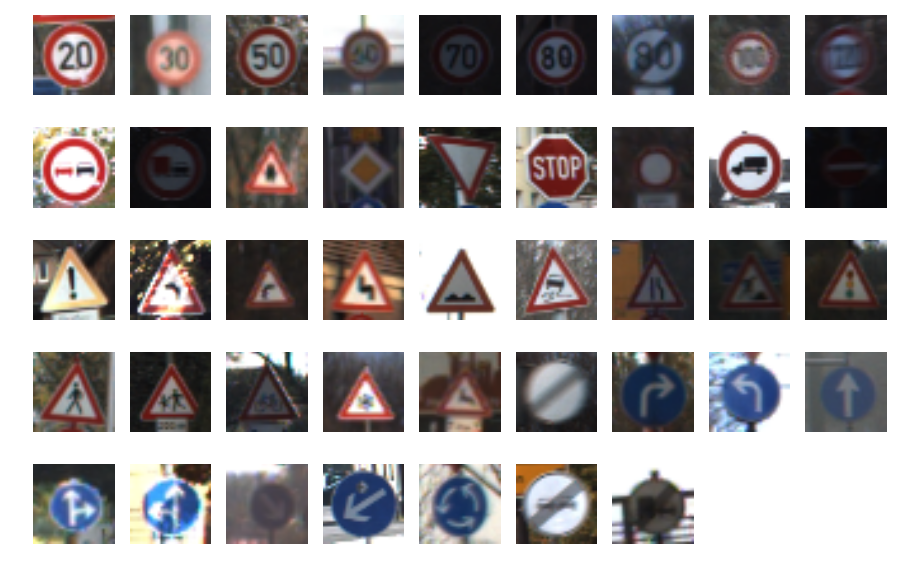

In [3]:
### Data exploration visualization goes here.
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# Visualizations will be shown in the notebook.
%matplotlib inline

gs1 = gridspec.GridSpec(5, 9)
plt.figure(figsize=(11,7))
for i in range(n_classes):
    data = X_train[y_train == i]
    index = random.randint(0, len(data) - 1)
    image = data[index].squeeze()
    
    ax1 = plt.subplot(gs1[i])
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')

    plt.subplot(5, 9, i + 1)
    plt.imshow(image)
    plt.axis('off')

plt.show()


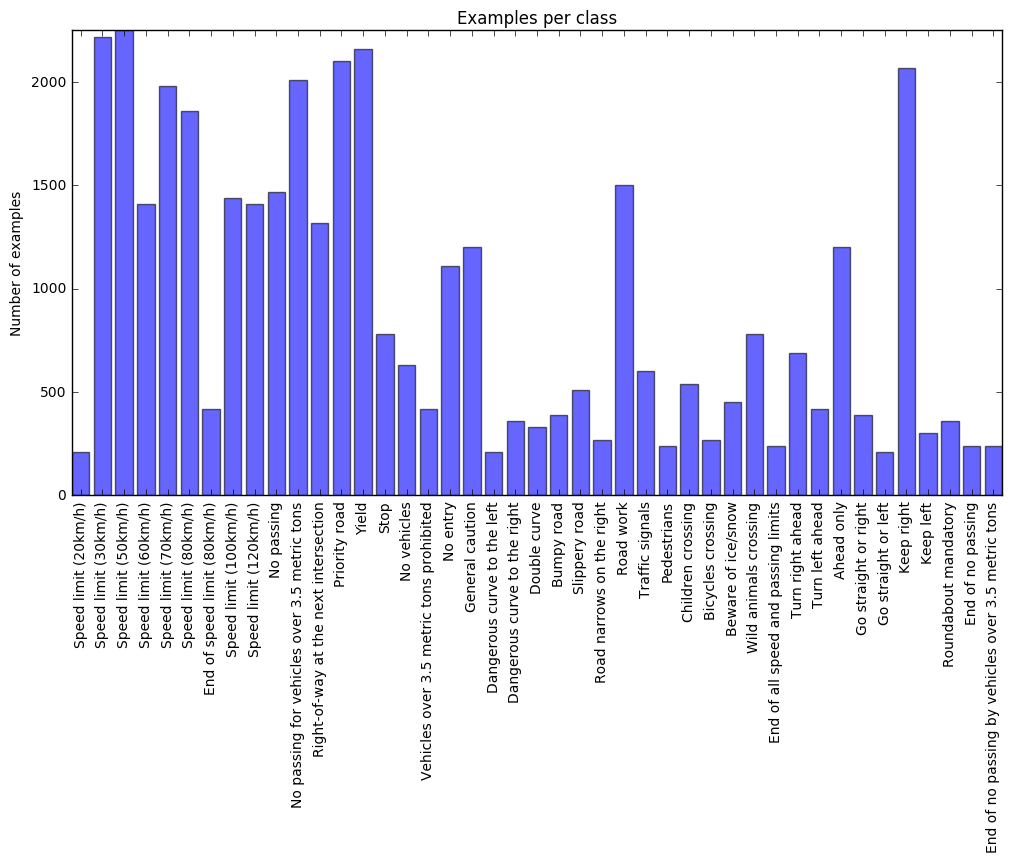

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
y_pos = np.arange(0, len(signnames))

plt.bar(y_pos, num_per_label, align='center', width=0.8, alpha=0.6)
plt.xticks(y_pos, signnames)
ax.set_xticklabels(signnames, rotation=90)
plt.ylabel('Number of examples')
plt.title('Examples per class')
plt.axis('tight')

plt.show()


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [5]:
X_train = X_train / 255.
X_test = X_test / 255.

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**
The data was scaled down to a range 0-1, because the optmizer works better with smaller numbers.

In [6]:
import cv2
def distort(img, max_rotation, max_shift, max_scale):
    w, h, _ = img.shape

    rot_angle = np.random.uniform(0, 2 * max_rotation) - max_rotation
    sc = 1 + np.random.uniform(0, 2 * max_scale) - max_scale
    r_mat = cv2.getRotationMatrix2D((w / 2, h / 2), rot_angle, sc)

    # Translation
    tr_x = np.random.uniform(0, 2 * max_shift) - max_shift
    tr_y = np.random.uniform(0, 2 * max_shift) - max_shift
    t_mat = np.float32([[1,0,tr_x],[0,1,tr_y]])

    img = cv2.warpAffine(img, r_mat, (w, h))
    img = cv2.warpAffine(img, t_mat, (w, h))
    
    return img

In [7]:
### Generate data additional data (OPTIONAL!)
most_populous = np.max(num_per_label)
missing = most_populous - num_per_label
n_missing = np.sum(missing)
print("Number of examples to be generated = ", n_missing)

X_fake = np.zeros((n_missing, X_train[0].shape[0], X_train[0].shape[1], X_train[0].shape[2]))
y_fake = np.zeros(n_missing)
cur = 0
for i in range(n_classes):
    data = X_train[y_train == i]
    n_data = len(data)
    for j in range(missing[i]):
        index = random.randint(0, n_data - 1)
        image = data[index]
        X_fake[cur] = distort(image, 20, 5, 0.2)
        y_fake[cur] = i
        cur = cur + 1
print('Data shapes: ')      
print('X_fake = ', X_fake.shape)
print('y_fake = ', y_fake.shape)
print('X_train = ', X_train.shape)
print('y_frain = ', y_train.shape)

Number of examples to be generated =  57541
Data shapes: 
X_fake =  (57541, 32, 32, 3)
y_fake =  (57541,)
X_train =  (39209, 32, 32, 3)
y_frain =  (39209,)


In [8]:
X_train = np.concatenate((X_train, X_fake), axis=0)
y_train = np.concatenate((y_train, y_fake), axis=0)

In [9]:
### and split the data into training/validation/testing sets here.
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = \
    train_test_split(X_train, y_train, test_size=0.20, random_state=42, stratify=y_train)
    
    
n_train = len(X_train)
n_validation = len(X_validation)
n_test = len(X_test)

_, num_per_label_train = np.unique(y_train, return_counts=True)
_, num_per_label_validation = np.unique(y_validation, return_counts=True)
_, num_per_label_test = np.unique(y_test, return_counts=True)

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of test examples =", n_test)

np.set_printoptions(precision=3)
print("Training set class ratios   =", num_per_label_train / n_train)
print("Validation set class ratios =", num_per_label_validation / n_validation)
print("Test set class ratios       =", num_per_label_test / n_test)


Number of training examples = 77400
Number of validation examples = 19350
Number of test examples = 12630
Training set class ratios   = [ 0.023  0.023  0.023  0.023  0.023  0.023  0.023  0.023  0.023  0.023
  0.023  0.023  0.023  0.023  0.023  0.023  0.023  0.023  0.023  0.023
  0.023  0.023  0.023  0.023  0.023  0.023  0.023  0.023  0.023  0.023
  0.023  0.023  0.023  0.023  0.023  0.023  0.023  0.023  0.023  0.023
  0.023  0.023  0.023]
Validation set class ratios = [ 0.023  0.023  0.023  0.023  0.023  0.023  0.023  0.023  0.023  0.023
  0.023  0.023  0.023  0.023  0.023  0.023  0.023  0.023  0.023  0.023
  0.023  0.023  0.023  0.023  0.023  0.023  0.023  0.023  0.023  0.023
  0.023  0.023  0.023  0.023  0.023  0.023  0.023  0.023  0.023  0.023
  0.023  0.023  0.023]
Test set class ratios       = [ 0.005  0.057  0.059  0.036  0.052  0.05   0.012  0.036  0.036  0.038
  0.052  0.033  0.055  0.057  0.021  0.017  0.012  0.029  0.031  0.005
  0.007  0.007  0.01   0.012  0.007  0.038  0.01

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**
The test data provided was left untouched and it consists of 12630 examples. The training data had imbalanced number of examples for different classes and for fixing that 57541 artificial samples were generated by random rotations, shifts and scalings. After merging them with the original training data they were split into a training set of 77400 examples and validation set of 19350. The split was made randomly.

In [10]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

keep_prob = tf.placeholder(tf.float32)
def LeNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    ######################
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28xconv1_depth.
    conv1_depth = 64
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, conv1_depth), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(conv1_depth))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.dropout(conv1, keep_prob)

    # SOLUTION: Pooling. Input = 28x28xconv1_depth. Output = 14x14xconv1_depth.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    #######################
    # SOLUTION: Layer 2: Convolutional. Output = 10x10xconv2_depth.
    conv2_depth = 64
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, conv1_depth, conv2_depth), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(conv2_depth))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.dropout(conv2, keep_prob)

    # SOLUTION: Pooling. Input = 10x10xconv2_depth. Output = 5x5xconv2_depth.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5xconv2_depth. Output = fc0_depth.
    fc0   = tf.concat(1, [flatten(conv1), flatten(conv2)])
    fc0_depth = 14*14*conv1_depth + 5*5*conv2_depth
    
    #######################
    # SOLUTION: Layer 3: Fully Connected. Input = fc0_depth. Output = fc1_depth.
    fc1_depth = 172
    fc1_W = tf.Variable(tf.truncated_normal(shape=(fc0_depth, fc1_depth), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(fc1_depth))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)
    fc1    = tf.nn.dropout(fc1, keep_prob)

    #######################
    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = fc2_depth.
    fc2_depth = 86
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(fc1_depth, fc2_depth), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(fc2_depth))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)
    fc2    = tf.nn.dropout(fc2, keep_prob)

    #######################
    # SOLUTION: Layer 5: Fully Connected. Input = fc2_depth. Output = n_classes.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(fc2_depth, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    L2_conv = tf.nn.l2_loss(conv1_W) + tf.nn.l2_loss(conv1_b) + tf.nn.l2_loss(conv2_W) + tf.nn.l2_loss(conv2_b)
    L2_fc = tf.nn.l2_loss(fc1_W) + tf.nn.l2_loss(fc1_b) + tf.nn.l2_loss(fc2_W) + tf.nn.l2_loss(fc2_b) + \
            tf.nn.l2_loss(fc3_W) + tf.nn.l2_loss(fc3_b)
    
    return logits, L2_conv, L2_fc


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


#### **Answer:**
The architecture of the network consists of 5 layers as follows:
 - 1) Convolution layer 1: 32x32x3 -> 28x28x64, max pooled to 14x14x64
 - 2) Convolution layer 2: 14x14x64 -> 10x10x64, max pooled to 5x5x64
 - 3) Fully connected layer 1: takes the output of the max pooled layers 1 and 2, and flatten them = 14144x172
 - 4) Fully connected layer 2: 172x86
 - 5) Fully connected layer 3: 86x43

All activations are ReLU units.

In [11]:
### Train your model here.
### Feel free to use as many code cells as needed.

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

EPOCHS = 30
BATCH_SIZE = 256
rate = 0.0002
beta = 0.001
dropout = 0.5

logits, L2_conv, L2_fc = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
regularization = beta * (L2_conv + L2_fc) if beta > 0 else 0.0
loss_operation = tf.reduce_mean(cross_entropy + regularization)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: dropout})
            
        training_accuracy = evaluate(X_train, y_train)
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, 'lenet')
    print("Model saved")


Training...

EPOCH 1 ...
Training Accuracy = 0.086
Validation Accuracy = 0.086

EPOCH 2 ...
Training Accuracy = 0.157
Validation Accuracy = 0.158

EPOCH 3 ...
Training Accuracy = 0.248
Validation Accuracy = 0.245

EPOCH 4 ...
Training Accuracy = 0.416
Validation Accuracy = 0.411

EPOCH 5 ...
Training Accuracy = 0.525
Validation Accuracy = 0.521

EPOCH 6 ...
Training Accuracy = 0.594
Validation Accuracy = 0.585

EPOCH 7 ...
Training Accuracy = 0.627
Validation Accuracy = 0.614

EPOCH 8 ...
Training Accuracy = 0.687
Validation Accuracy = 0.668

EPOCH 9 ...
Training Accuracy = 0.707
Validation Accuracy = 0.693

EPOCH 10 ...
Training Accuracy = 0.744
Validation Accuracy = 0.729

EPOCH 11 ...
Training Accuracy = 0.781
Validation Accuracy = 0.765

EPOCH 12 ...
Training Accuracy = 0.794
Validation Accuracy = 0.777

EPOCH 13 ...
Training Accuracy = 0.846
Validation Accuracy = 0.828

EPOCH 14 ...
Training Accuracy = 0.857
Validation Accuracy = 0.838

EPOCH 15 ...
Training Accuracy = 0.865
Valid

In [12]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.931


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**
The model was trained with the AdamOptimizer and a batch size of 256. The training happened in 30 epochs and the learning rate was 0.0002. Dropout of 0.5 was applied to the first 4 layers along with L2 regularization with beta = 0.001. Weights were initialized with a truncated_normal distribution, where mu = 0 and sigma = 0.1.

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**
My experiments started with the basic LeNet architecture. The process was mainly based on trial and error, where after the first test I noticed that there is a big difference between validation and test error. After noting that the number of examples per label are imbalanced, I decided to generate more artificial data. That made the two numbers, validation error and test error, much closer to one another. After gaining more confidence in the validation error, I started experimenting with the hyperparameters, because I had no access to a GPU instance initially, so I was restricted with a small network. However, the last few hours before the deadline, I had been given access to an AWS GPU instance and that resulted in more experiments with the network architecture, which improved my results with up to 0.05 points. I have used the Yann LeCun's Traffic Sign paper for inspiration, however I didn't have time to test all of the ideas presented there.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

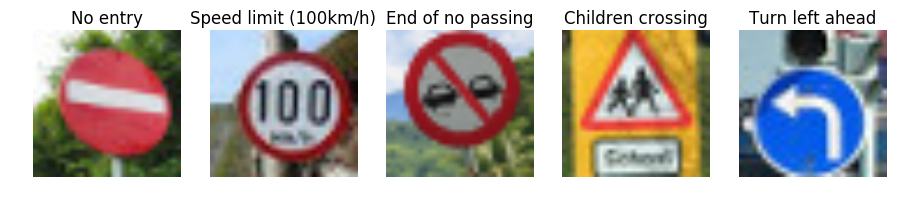

In [13]:
### Load the images and plot them here.
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# Visualizations will be shown in the notebook.
%matplotlib inline

signs = [
    'custom/sign1.jpg',
    'custom/sign2.jpg',
    'custom/sign3.jpg',
    'custom/sign4.jpg',
    'custom/sign5.jpg'
]

X_manual = np.zeros((5,32,32,3))

y_manual = [
    17,
    7,
    41,
    28,
    34
]

gs1 = gridspec.GridSpec(1, 5)
plt.figure(figsize=(11,7))
for i in range(len(signs)):
    image = cv2.imread(signs[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    X_manual[i] = image / 255.
    
    ax1 = plt.subplot(gs1[i])
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')

    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.title(signnames[y_manual[i]])
    plt.axis('off')

plt.show()


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**
I have taken five images from the internet. Some of the images are of signs with different style from the ones in the database and that might prove difficult, especially the speed limit and end of no passing signs. The children crossing sign has additional text and is on a yellow background, so I suspect that it also might prove to be difficult for classification.

In [14]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_manual, y_manual)
    print("Manual Test Accuracy = {:.3f}".format(test_accuracy))

Manual Test Accuracy = 0.800


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**
My model is performing worse than the test cases on the dataset. I fails to classify 1 out of 5 images.

In [15]:
### Visualize the softmax probabilities here.
result = tf.nn.softmax(logits)
topK = tf.nn.top_k(result, k=5)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    hello = sess.run(topK, feed_dict={x: X_manual, y: y_manual, keep_prob: 1.0})
### Feel free to use as many code cells as needed.

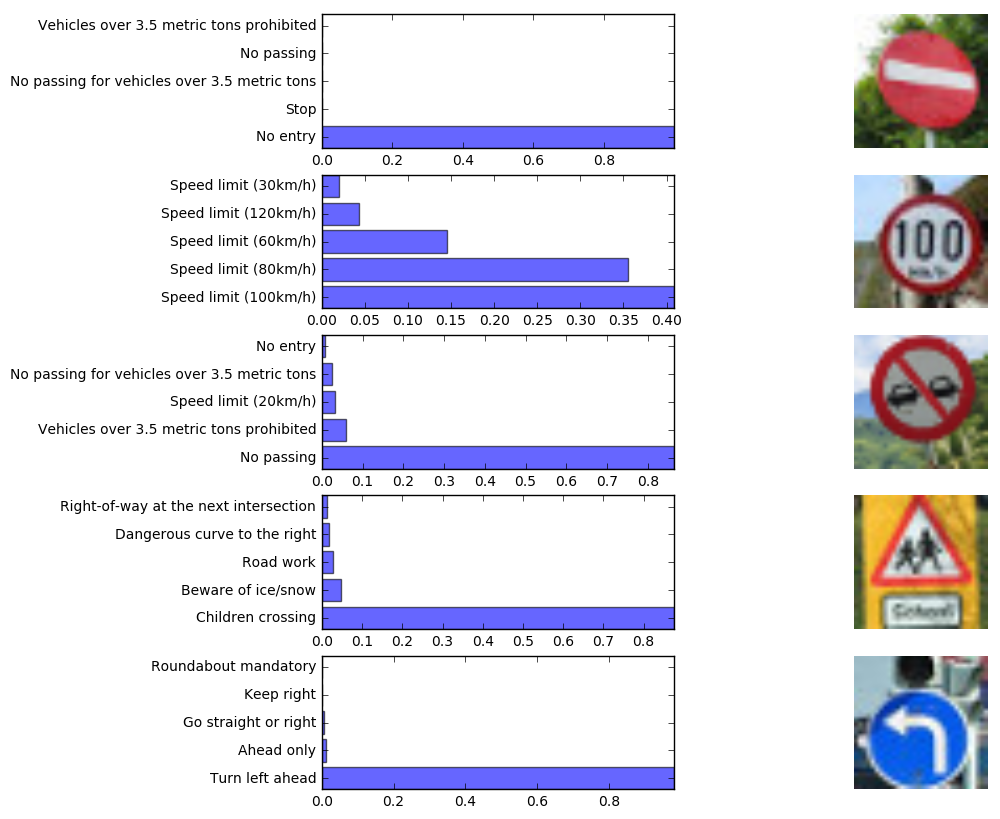

In [16]:
### Load the images and plot them here.
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# Visualizations will be shown in the notebook.
%matplotlib inline

gs1 = gridspec.GridSpec(5, 2)
plt.figure(figsize=(10,10))
for i in range(len(signs)):
    image = cv2.imread(signs[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Plot image
    ax1 = plt.subplot(gs1[2 * i + 1])
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')

    plt.subplot(5, 2, 2 * i + 2)
    plt.imshow(image)
    plt.axis('off')
    
    # Plot barchart
    ax1 = plt.subplot(gs1[2 * i])
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    
    plt.subplot(5, 2, 2 * i + 1)

    indices = hello.indices[i].tolist()
    values = hello.values[i].tolist()
    y_pos = np.arange(0, len(indices))
    names = [signnames[j] for j in indices]

    plt.barh(y_pos, values, align='center', height=0.8, alpha=0.6)
    plt.yticks(y_pos, names)
    ax.set_yticklabels(names, rotation=90)
    ax.yaxis.set_label_position("right")
    plt.axis('tight')
    
plt.show()

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

My model appears to be quite certain with the correct predictions of **no entry**, **children crossing** and **turn left ahead** signs. However it is also quite certain about the **end of no passing** sign and it predicts it wrongly to be a **no passing** sign. This is due to the fact that it is an unseen sign, possibly from a different country. The **end of no passing** is not even among the top 5 choices, which makes it a pretty bad prediction. Predicting the **speed limit of 100** is very uncertain and the model finds it almost equally likely that the sign could be a **speed limit of 80** or even a bit likely to be a **speed limit of 60** sign. It seems that the model has trouble distinguishing the number in the circle.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.